[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/Toxic_comments/blob/main/toxic_comments.ipynb)

Реализация классификатора токсичных комментариев на базе датасета
https://www.kaggle.com/datasets/blackmoon/russian-language-toxic-comments  

Дубликат файла: https://cloud.mail.ru/public/Z4L3/vB8GcgTtK

In [15]:
import time

import numpy as np
import pandas as pd


import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer#, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
#from tqdm import tqdm, trange
#import io
from sklearn.metrics import accuracy_score
#import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [16]:
# архитектура модели + 
# загрузчик данных +
# формирование батча +
# инициализировать модель +
# оптимизатор +
# функция потерь +
# опционально шедулеры -
# трейн луп

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3090


## Загрузка данных

In [18]:
dataset = pd.read_csv('labeled.csv')
dataset

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\r\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\r\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


Датасет представляет собой таблицу размеченных комментариев (является ли toxic-abuse)

In [19]:
sentences = dataset['comment'].values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = [[1] if label == 1 else [0] for label in dataset['toxic'].values]

assert len(sentences) == len(labels)

print(sentences[24])

[CLS] Да какая агрессия. Тебя ткнули в твое же дерьмо. Обтекай. Это я без отрицательных эмоций. Просто факт.
 [SEP]


Выделение отложенной (тестовой) выборки

In [20]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.15)

print(len(train_gt), len(test_gt))

print(f"Размер обучающей и валидационной выборки: {len(train_gt)}")
print(f"Размер отложенной (тестовой) выборки: {len(test_gt)}")

12250 2162
Размер обучающей и валидационной выборки: 12250
Размер отложенной (тестовой) выборки: 2162


In [21]:
train_sentences

['[CLS] Сообщение просто сгусток интеллекта.\r\n [SEP]',
 '[CLS] Не давал бы пушистому лизать кофе. Тельце маленькое, может инфаркт ебнуть.\r\n [SEP]',
 '[CLS] Зерно не начали закупать ещё 60-е, а просто в 60-е вынуждены были закупить. Хм... Запишу в копилку к Не спал, а засыпал .\r\n [SEP]',
 '[CLS] Вчерась пацан лет 8 в магазине телефон сует продавцу что бы та считала карту магазина,та охуев от 10 Айфона спрашивает- это мамы телефон?! ,пацан говорит- нет,мой и удаляется с корешем в даль есть купленные печеньки, ещё и чеки взяли сорванцы,я конечно тоже в ахуе был... [SEP]',
 '[CLS] все звонки в службы спасения записываются, а звонки в скорую и вызов скорой в больницу, где уже должны оказывать квалифицированную помощь говорит о несостоятельности больницы. Приезд скорой тоже фиксируется, как и оказанная ею помощь. Очень большой шанс, что после этих звонков всю информацию передадут в надзорные органы даже без вашего участия.\r\n [SEP]',
 '[CLS] Чем старше набор - тем дороже он сейчас цен

In [22]:
test_sentences

['[CLS] Хохловский самый последовательный из всех них. У всех остальных так или иначе присутствуют чёрные пятна и двойные стандарты в идеологии из-за чего и происходит перманентный срач.\r\n [SEP]',
 '[CLS] У меня нет проблем выпилить под нужную форму. Да и платы халявные. И часто я иду именно от оправы, когда людЯм вес критичен. Ну в смысле цена за грамм. А под форму оправы проще выпилить.\r\n [SEP]',
 '[CLS] Во всем виноваты белые расисты. Феминизм победит.\r\n [SEP]',
 '[CLS] Зато как хороша вокалистка!\r\n [SEP]',
 '[CLS] Левак, плз. Дело не в формации, а в том что есть тупое быдло, и есть контент для тупого быдла. И при твоей новой формации это быдло никуда не денется, это в природе вещей.\r\n [SEP]',
 '[CLS] Почему сразу шлюхе? Мы ведь не знаем, порвала ли она с бывшим прежде, чем с новым гулять. Люди иногда влюбляются - так бывает.\r\n [SEP]',
 '[CLS] Жопу рвать вас никто не просит, ровно как и поэмы писать. Тут так принято, делаешь пост, делай его полноценно, а не так, накидал 

Токенизация текста

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)  # bert-base модель BERT с 12 s-attention модулями
                                                                                    # uncased - все слова в нижнем регистре
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

['[CLS]', 'с', '##о', '##о', '##б', '##щ', '##е', '##н', '##и', '##е', 'п', '##р', '##о', '##с', '##т', '##о', 'с', '##г', '##у', '##с', '##т', '##о', '##к', 'и', '##н', '##т', '##е', '##л', '##л', '##е', '##к', '##т', '##а', '.', '[SEP]']


In [24]:
MAX_LEN_SENTENCE = 512
BATCH_SIZE = 16

Формирование inputs (id токенов и маски)

In [25]:
def make_input(tokenized_texts):
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    input_ids = pad_sequences(input_ids,
                              maxlen=MAX_LEN_SENTENCE,
                              dtype="long",
                              truncating="post",
                              padding="post"
                              )
    
    attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

    return input_ids, attention_masks

input_ids, attention_masks = make_input(tokenized_texts)

Token indices sequence length is longer than the specified maximum sequence length for this model (1079 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1111 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Разбиение обучающей обучающей выборки на обучающую и валидационную

In [26]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

Преобразавание inpurs в тензоры

In [27]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_labels

tensor([[1],
        [0],
        [0],
        ...,
        [1],
        [0],
        [0]])

## Формирование батча

In [28]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data,
                              sampler=RandomSampler(train_data),
                              batch_size=BATCH_SIZE,
                              )

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(validation_data,
                                   sampler=SequentialSampler(validation_data),
                                   batch_size=BATCH_SIZE
                                   )

## Инициализация модели и задание оптимизатора

In [29]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
try:
    model.cuda()
except:
    pass

In [30]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)    # рекомендуется 5e-5 / 3e-5 / 2e-5

## Обучение модели

In [31]:
def train(model, dataloader, optimizer, train_loss_history=None, valid_loss_history=None,
          train_accuracy_history=None, valid_accuracy_history=None):

    # Переводим модель в training mode
    model.train()
    
    # Будем сохранять loss во время обучения и рисовать график в режиме реального времени
    epoch_loss = 0
    loss_history = []

    train_preds, train_labels = [], []
    
    for step, batch in enumerate(dataloader):
        
        # добавляем батч для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)
        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # если не сделать .zero_grad(), градиенты будут накапливаться
        optimizer.zero_grad()
        
        # Forward pass
        loss, logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss_history.append(loss.item())  
        
        # Backward pass
        loss.backward()
        
        # Обновляем параметры и делаем шаг используя посчитанные градиенты
        optimizer.step()

        # Обновляем loss
        epoch_loss += loss.item()
        
        # Перемещаем logits и метки классов на CPU для дальнейшей работы
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
            
        batch_preds = np.argmax(logits, axis=1)
        batch_labels = np.concatenate(label_ids)     
        train_preds.extend(batch_preds)
        train_labels.extend(batch_labels)

        # Рисуем график
        
        if (step+1)%10==0:
            
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
            
            clear_output(True)           
            ax[0].plot(loss_history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title(f'Train loss current epoch')
            if train_loss_history is not None:
                ax[1].plot(train_loss_history, label='Train')
            if valid_loss_history is not None:
                ax[1].plot(valid_loss_history, label='Valid')
            if (train_loss_history is not None) or (valid_loss_history is not None):
                ax[1].set_xlabel('Epoch')
                ax[1].set_title('General loss history')
                ax[1].legend()
            if train_accuracy_history is not None:
                ax[2].plot(train_accuracy_history, label='Train')
            if valid_accuracy_history is not None:
                ax[2].plot(valid_accuracy_history, label='Valid')   
            if (train_accuracy_history is not None) or (valid_accuracy_history is not None):        
                ax[2].set_xlabel('Epoch')
                ax[2].set_title('General accuracy history')
                ax[2].legend()
            plt.show()
        
    loss = epoch_loss / len(dataloader)
    accuracy = accuracy_score(train_labels, train_preds) * 100

    return loss, accuracy

#train_history = []
#valid_history = []
#train_accuracy_history = []
#valid_accuracy_history = []

#train(model, train_dataloader, optimizer, train_history, valid_history, train_accuracy_history, valid_accuracy_history)

In [32]:
def evaluate(model, dataloader):
    
    # Переводим модель в evaluation mode
    model.eval()
    
    epoch_loss = 0
    
    valid_preds, valid_labels = [], []
    
    for batch in dataloader:
        
        # добавляем батч для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)
            
        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch            

        # При использовании .no_grad() модель не будет считать и хранить градиенты.
        with torch.no_grad():
            loss, logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            
        epoch_loss += loss.item()

        # Перемещаем logits и метки классов на CPU для дальнейшей работы
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
            
        batch_preds = np.argmax(logits, axis=1)
        batch_labels = np.concatenate(label_ids)     
        valid_preds.extend(batch_preds)
        valid_labels.extend(batch_labels)

    loss = epoch_loss / len(dataloader)
    accuracy = accuracy_score(valid_labels, valid_preds) * 100

    return loss, accuracy

#evaluate(model, validation_dataloader)

In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [34]:
def train_eval_loop(model, train_iterator, valid_iterator, model_name, N_EPOCHS=10):

    train_loss_history = []
    valid_loss_history = []
    
    train_accuracy_history = []
    valid_accuracy_history = []
    
    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):
        
        try:
        
            start_time = time.time()
            
            train_loss, train_accuracy = train(model, train_iterator, optimizer, train_loss_history, valid_loss_history,
                               train_accuracy_history, valid_accuracy_history)
            valid_loss, valid_accuracy = evaluate(model, valid_iterator)

            end_time = time.time()
            
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)
            
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                print('Новый минимальный лосс на валидации:', best_valid_loss, 'на', epoch, 'эпохе')
                torch.save(model.state_dict(), 'STATE_DICT_' + model_name)
                torch.save(model, model_name)

            train_loss_history.append(train_loss)
            valid_loss_history.append(valid_loss)

            train_accuracy_history.append(train_accuracy)
            valid_accuracy_history.append(valid_accuracy)

            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy:.2f}')
            print(f'\t Val. Loss: {valid_loss:.3f} | Val. Accuracy:  {valid_accuracy:.2f}')
        
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break

    return None

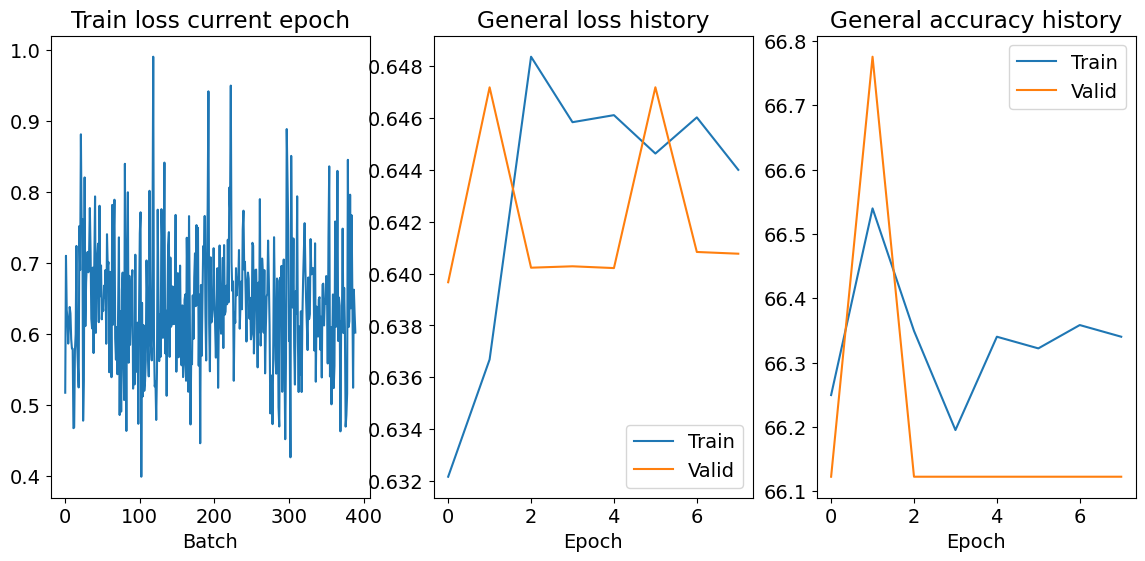

Досрочно остановлено пользователем


In [19]:
2e

MODEL_NAME = 'BERT_CLS_TOXIC.pt'

train_eval_loop(model, train_dataloader, validation_dataloader, model_name=MODEL_NAME, N_EPOCHS=30)

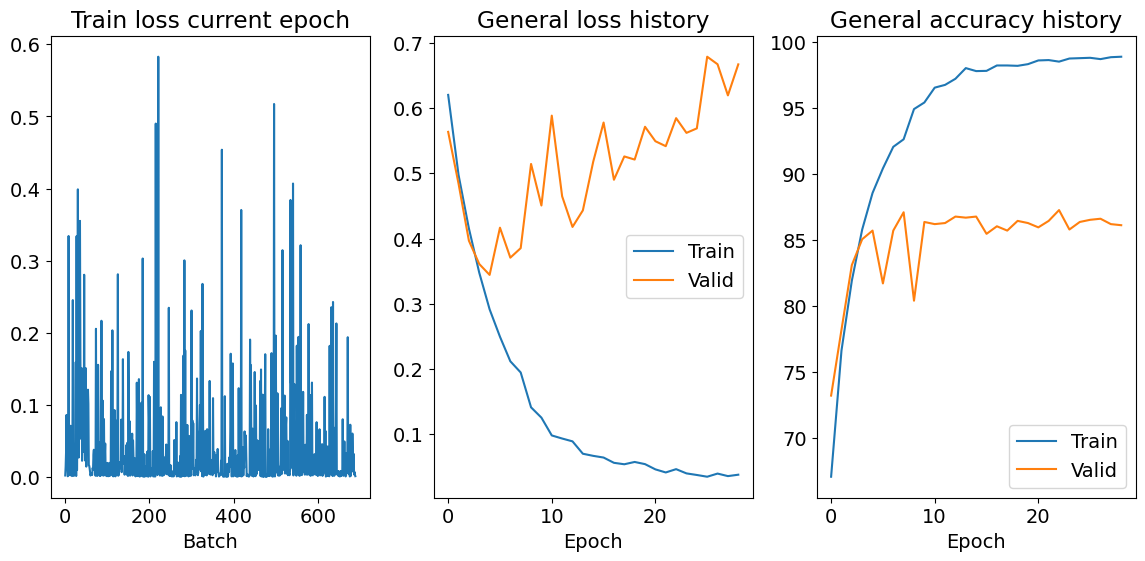

Epoch: 30 | Time: 4m 57s
	Train Loss: 0.041 | Train Accuracy: 98.48
	 Val. Loss: 0.664 | Val. Accuracy:  85.71


In [26]:
3
MODEL_NAME = 'BERT_CLS_TOXIC.pt'

train_eval_loop(model, train_dataloader, validation_dataloader, model_name=MODEL_NAME, N_EPOCHS=30)

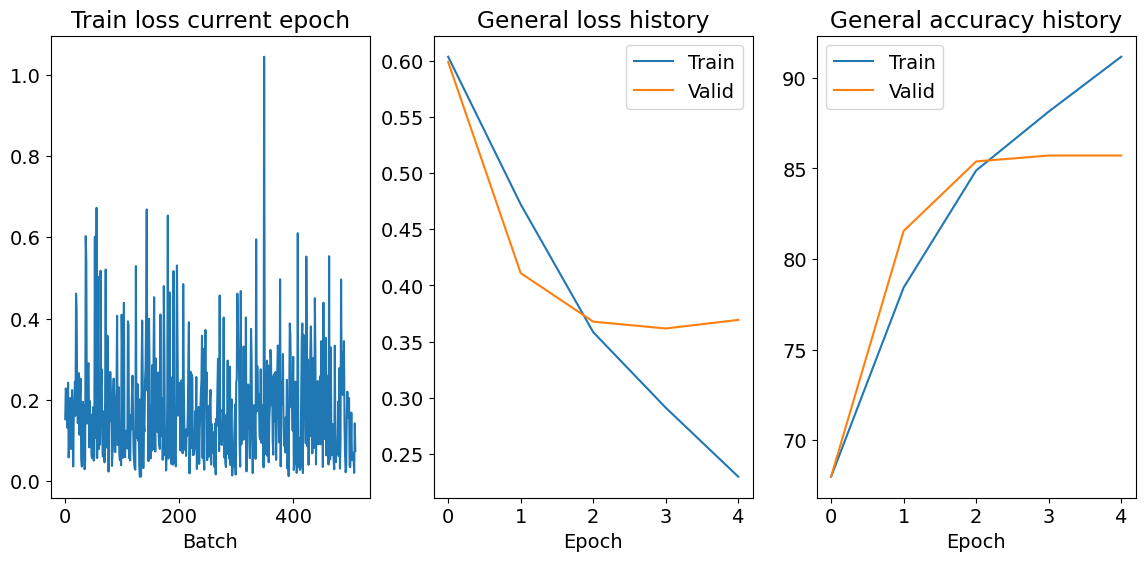

Досрочно остановлено пользователем


In [36]:
MODEL_NAME = 'BERT_CLS_TOXIC.pt'

train_eval_loop(model, train_dataloader, validation_dataloader, model_name=MODEL_NAME, N_EPOCHS=10)

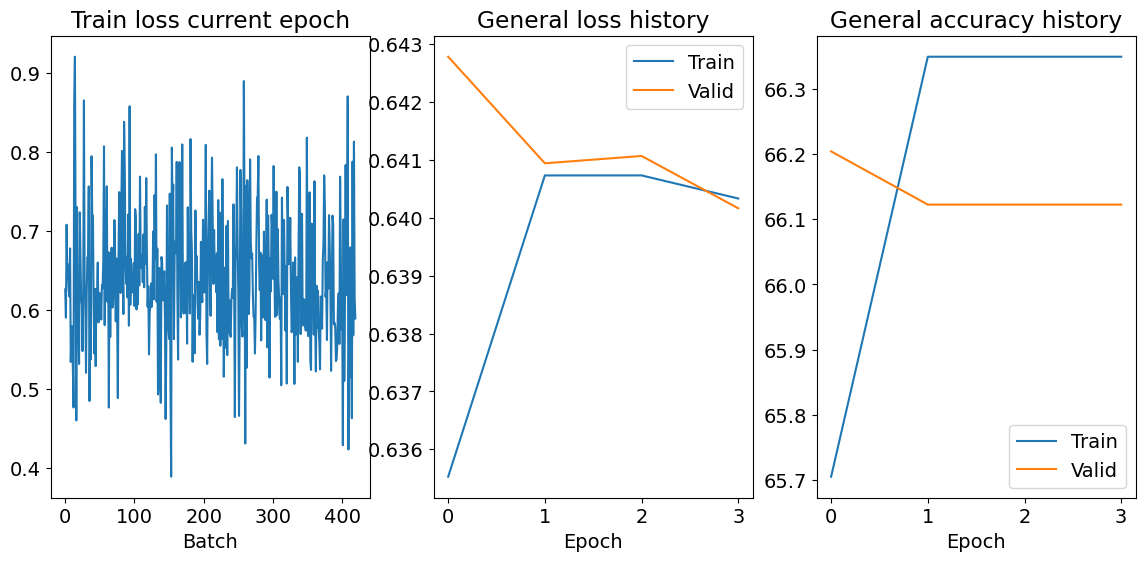

Досрочно остановлено пользователем


In [30]:
MODEL_NAME = 'BERT_CLS_TOXIC_5.pt'

train_eval_loop(model, train_dataloader, validation_dataloader, model_name=MODEL_NAME, N_EPOCHS=10)

In [39]:
MODEL_NAME = 'STATE_DICT_' + 'BERT_CLS_TOXIC.pt'

In [40]:
model.load_state_dict(torch.load(MODEL_NAME))

<All keys matched successfully>

Finally, we load the parameters from our best validation loss and get our results on the test set.

In [ ]:
#Мы загружаем наши «лучшие» параметры и добиваемся большей точности при тестировании, чем достигали все предыдущие модели.
model.load_state_dict(torch.load(MODEL_NAME))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

## Оценка качества на отложенной выборке

In [45]:
test_tokenized = [tokenizer.tokenize(sent) for sent in test_sentences]

test_inputs, test_masks = make_input(test_tokenized)

test_inputs = torch.tensor(test_inputs)
test_masks = torch.tensor(test_masks)
test_labels = torch.tensor(test_gt)

test_data = TensorDataset(test_inputs,
                          test_masks,
                          test_labels
                          )

test_dataloader = DataLoader(test_data,
                             sampler=SequentialSampler(test_data),
                             batch_size=BATCH_SIZE
                             )

Token indices sequence length is longer than the specified maximum sequence length for this model (999 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (721 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

In [51]:
_, test_accuracy = evaluate(model, test_dataloader)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(test_accuracy))

Процент правильных предсказаний на отложенной выборке составил: 92.28%


In [ ]:
tfidf

# логистическая регрессия
0.8488225399495374
0.7233551365909966

# svc
0.8591253153910849
0.7486871717929482

# LinearSVC
0.8708999158957107
0.7869535045107565

# градиентный бустинг
0.7714465937762826
0.4965261695229273

# случайный лес
0.8269554247266611
0.713340299547196

In [379]:
phrase = "Хорошая погода"
print(f"Фраза: {phrase}")
print("\nКлассификация с помощью логистической регрессии:")
print(predict_logreg(phrase))
print("\nКлассификация с помощью SVC:")
print(predict_svc(phrase))
print("\nКлассификация с помощью LinearSVC:")
print(predict_linearSVC(phrase))
print("\nКлассификация с помощью градиентного бустинга:")
print(predict_RandForest(phrase))
print("\nКлассификация с помощью случайного леса:")
print(predict_GradBst(phrase))
print("\nКлассификация с помощью стэкинга:")
print(predict_Stacking_models(phrase))

Фраза: Хорошая погода

Классификация с помощью логистической регрессии:
The comment isn't toxic

Классификация с помощью SVC:
The comment isn't toxic

Классификация с помощью LinearSVC:
The comment isn't toxic

Классификация с помощью градиентного бустинга:
The comment isn't toxic

Классификация с помощью случайного леса:
The comment isn't toxic

Классификация с помощью стэкинга:
The comment isn't toxic


In [380]:
phrase = "Меня окружают одни идиоты"
print(f"Фраза: {phrase}")
print("\nКлассификация с помощью логистической регрессии:")
print(predict_logreg(phrase))
print("\nКлассификация с помощью SVC:")
print(predict_svc(phrase))
print("\nКлассификация с помощью LinearSVC:")
print(predict_linearSVC(phrase))
print("\nКлассификация с помощью градиентного бустинга:")
print(predict_RandForest(phrase))
print("\nКлассификация с помощью случайного леса:")
print(predict_GradBst(phrase))
print("\nКлассификация с помощью стэкинга:")
print(predict_Stacking_models(phrase))

Фраза: Меня окружают одни идиоты

Классификация с помощью логистической регрессии:
The comment is toxic

Классификация с помощью SVC:
The comment is toxic

Классификация с помощью LinearSVC:
The comment is toxic

Классификация с помощью градиентного бустинга:
The comment is toxic

Классификация с помощью случайного леса:
The comment isn't toxic

Классификация с помощью стэкинга:
The comment is toxic


In [381]:
phrase = "Тупоголовые дебилы"
print(f"Фраза: {phrase}")
print("\nКлассификация с помощью логистической регрессии:")
print(predict_logreg(phrase))
print("\nКлассификация с помощью SVC:")
print(predict_svc(phrase))
print("\nКлассификация с помощью LinearSVC:")
print(predict_linearSVC(phrase))
print("\nКлассификация с помощью градиентного бустинга:")
print(predict_RandForest(phrase))
print("\nКлассификация с помощью случайного леса:")
print(predict_GradBst(phrase))
print("\nКлассификация с помощью стэкинга:")
print(predict_Stacking_models(phrase))

Фраза: Тупоголовые дебилы

Классификация с помощью логистической регрессии:
The comment is toxic

Классификация с помощью SVC:
The comment is toxic

Классификация с помощью LinearSVC:
The comment is toxic

Классификация с помощью градиентного бустинга:
The comment is toxic

Классификация с помощью случайного леса:
The comment is toxic

Классификация с помощью стэкинга:
The comment is toxic


In [382]:
phrase = "всех чертей расстрелять"
print(f"Фраза: {phrase}")
print("\nКлассификация с помощью логистической регрессии:")
print(predict_logreg(phrase))
print("\nКлассификация с помощью SVC:")
print(predict_svc(phrase))
print("\nКлассификация с помощью LinearSVC:")
print(predict_linearSVC(phrase))
print("\nКлассификация с помощью градиентного бустинга:")
print(predict_RandForest(phrase))
print("\nКлассификация с помощью случайного леса:")
print(predict_GradBst(phrase))
print("\nКлассификация с помощью стэкинга:")
print(predict_Stacking_models(phrase))

Фраза: всех чертей расстрелять

Классификация с помощью логистической регрессии:
The comment is toxic

Классификация с помощью SVC:
The comment is toxic

Классификация с помощью LinearSVC:
The comment is toxic

Классификация с помощью градиентного бустинга:
The comment is toxic

Классификация с помощью случайного леса:
The comment isn't toxic

Классификация с помощью стэкинга:
The comment isn't toxic


In [383]:
phrase = "пес по кличке балбес"
print(f"Фраза: {phrase}")
print("\nКлассификация с помощью логистической регрессии:")
print(predict_logreg(phrase))
print("\nКлассификация с помощью SVC:")
print(predict_svc(phrase))
print("\nКлассификация с помощью LinearSVC:")
print(predict_linearSVC(phrase))
print("\nКлассификация с помощью градиентного бустинга:")
print(predict_RandForest(phrase))
print("\nКлассификация с помощью случайного леса:")
print(predict_GradBst(phrase))
print("\nКлассификация с помощью стэкинга:")
print(predict_Stacking_models(phrase))

Фраза: пес по кличке балбес

Классификация с помощью логистической регрессии:
The comment is toxic

Классификация с помощью SVC:
The comment is toxic

Классификация с помощью LinearSVC:
The comment is toxic

Классификация с помощью градиентного бустинга:
The comment is toxic

Классификация с помощью случайного леса:
The comment isn't toxic

Классификация с помощью стэкинга:
The comment isn't toxic


In [384]:
phrase = "воинствующий идиот"
print(f"Фраза: {phrase}")
print("\nКлассификация с помощью логистической регрессии:")
print(predict_logreg(phrase))
print("\nКлассификация с помощью SVC:")
print(predict_svc(phrase))
print("\nКлассификация с помощью LinearSVC:")
print(predict_linearSVC(phrase))
print("\nКлассификация с помощью градиентного бустинга:")
print(predict_RandForest(phrase))
print("\nКлассификация с помощью случайного леса:")
print(predict_GradBst(phrase))
print("\nКлассификация с помощью стэкинга:")
print(predict_Stacking_models(phrase))

Фраза: воинствующий идиот

Классификация с помощью логистической регрессии:
The comment is toxic

Классификация с помощью SVC:
The comment is toxic

Классификация с помощью LinearSVC:
The comment is toxic

Классификация с помощью градиентного бустинга:
The comment is toxic

Классификация с помощью случайного леса:
The comment isn't toxic

Классификация с помощью стэкинга:
The comment is toxic


In [386]:
phrase = "Иди свиней паси"
print(f"Фраза: {phrase}")
print("\nКлассификация с помощью логистической регрессии:")
print(predict_logreg(phrase))
print("\nКлассификация с помощью SVC:")
print(predict_svc(phrase))
print("\nКлассификация с помощью LinearSVC:")
print(predict_linearSVC(phrase))
print("\nКлассификация с помощью градиентного бустинга:")
print(predict_RandForest(phrase))
print("\nКлассификация с помощью случайного леса:")
print(predict_GradBst(phrase))
print("\nКлассификация с помощью стэкинга:")
print(predict_Stacking_models(phrase))

Фраза: Иди свиней паси

Классификация с помощью логистической регрессии:
The comment is toxic

Классификация с помощью SVC:
The comment is toxic

Классификация с помощью LinearSVC:
The comment is toxic

Классификация с помощью градиентного бустинга:
The comment is toxic

Классификация с помощью случайного леса:
The comment is toxic

Классификация с помощью стэкинга:
The comment is toxic


In [354]:
phrase = "Винтажный газогенератор"
print(f"Фраза: {phrase}")
print("\nКлассификация с помощью логистической регрессии: ")
predict_logreg(phrase)
print("\nКлассификация с помощью градиентного бустинга: ")
predict_RandForest(phrase)
print("\nКлассификация с помощью случайного леса: ")
predict_GradBst(phrase)
print("\nКлассификация с помощью стэкинга: ")
predict_Stacking_models(phrase)

Фраза: Винтажный газогенератор

Классификация с помощью логистической регрессии: 
The comment isn't toxic [0.]

Классификация с помощью градиентного бустинга: 
The comment is toxic

Классификация с помощью случайного леса: 
The comment isn't toxic

Классификация с помощью стэкинга: 
The comment isn't toxic
